# Classifying Dog Breeds with Keras
## Abe Eyman Casey & Sameer Patel
The following code takes approximately 8 hours to run. Avoid running until necessary.

In [1]:
import keras
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

# Research Question
The intent of this analysis is to use machine learning methodologies and accessory data science tools to determine whether a neural network can be trained to accurately predict a dog breed based on "looking" at an image containing a dog. 

This exploration will consist of the following:  
* Loading the data  
* Exploratory data analysis (EDA)  
* Data preprocessing  
* Model building
   - Keras Convolutional Neural Network  
* Model evaluation / visualizations
* Conclusion / future analyses

The conclusion will assess the efficacy of the trained neural network based on the metrics returned in the model evaluation phase, as well as suggest future routes of exploration related to this problem.

# Load the Data
https://www.kaggle.com/c/dog-breed-identification/overview  
The data set contains a training set and a test set of images of dogs.  
For this exploration, we will exclusively use the training set (train.zip), but will split it in order to obtain a labeled test set.  
The training set contains over 10,000 images split into 120 breeds of dogs. Because of this, the data is not available in the Git repository, and will need to be downloaded separately from the link provided above (if running this code on a new machine).

Each image has a filename that is its unique id.

In [3]:
#Return number of images in the training data directory (saved locally to the path given below)
train_path = 'data/train'
train_size = len(os.listdir(train_path))
print("Number of Images: %s" % train_size)

Number of Images: 10222


In [4]:
labels_df = pd.read_csv('data/labels.csv')
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
all_breeds = labels_df.sort_values(by = "breed").filter(['breed']).drop_duplicates().reset_index(drop = True)
print('Number of dog breeds: %s' % len(all_breeds.breed))
print("\nList of Unique Breeds:")
print(all_breeds.breed.unique())

Number of dog breeds: 120

List of Unique Breeds:
['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier'

# Exploratory data analysis (EDA)
Because the data is explicitly labeled images of dog breeds, graphic options for EDA are somewhat limited.

In this section we will evaluate the balance of the classes using a histogram. In the writeup, we will include sample images displaying the range of image types that are contained within this dataset (eg. pictures with multiple dogs, varying levels of zoom/blur, other animals, etc).

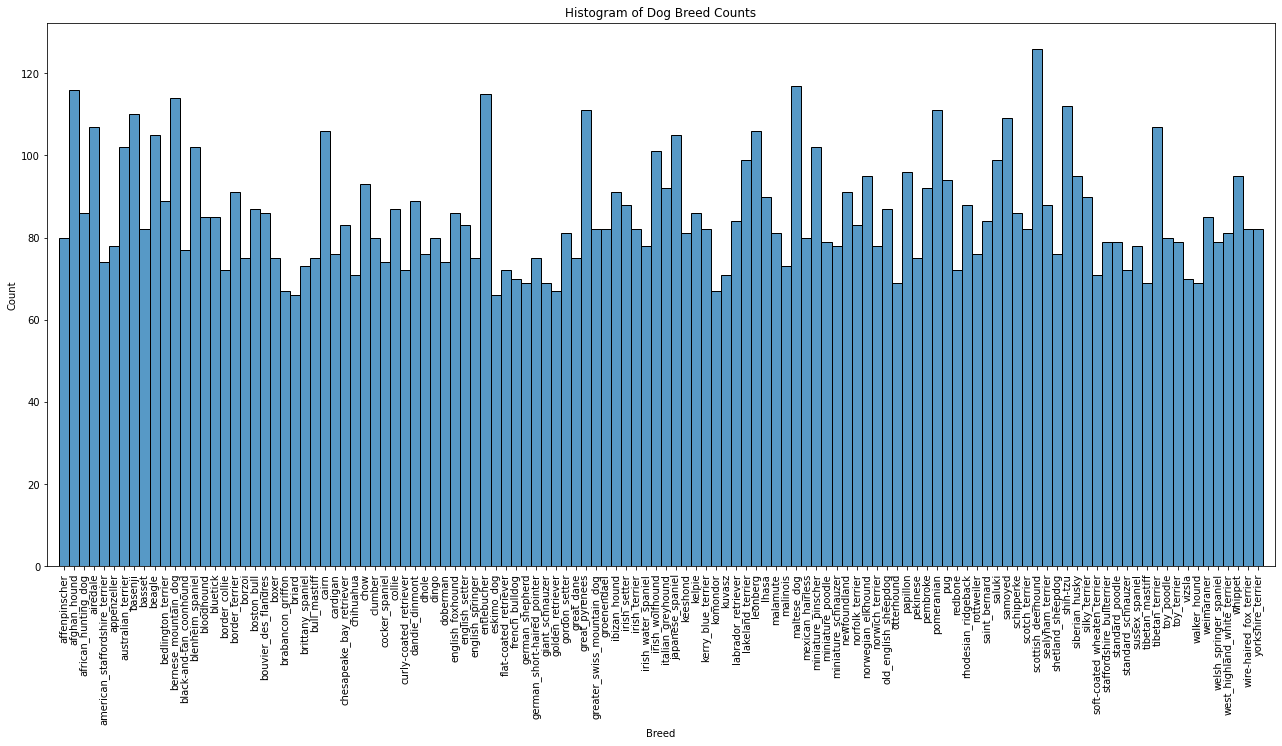

In [6]:
fig,ax = plt.subplots(figsize=(22,10));
ax.margins(x=.01);
sns.histplot(data=labels_df,x=labels_df.breed.sort_values(),ax=ax);
plt.title("Histogram of Dog Breed Counts")
plt.xticks(rotation=90);
plt.xlabel("Breed");

# Data Preprocessing
First we will use the ImageDataGenerator class from the keras library to perform data augmentation on the images in the dataset. The generator applies a series of random transformations to each image in the batch and replaces the training images with a set of new images for future usage in model training.

Several transformations are possible using the ImageDataGenerator function, but because of the large number of images already present in the training dataset, the team opted to only apply the horizontal_flip transformation to augment the training data. More augmentations would theoretically increase the accuracy of the model for predicting unlabeled images, but the additional computational cost is not justifiable for the purposes of this exploration.

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip = True,
                                   validation_split = 0.1
                                   #rotation_range = 20,
                                   #brightness_range=[0.2,1.0],
                                   #width_shift_range = 0.2,
                                   #height_shift_range = 0.2,
                                   #shear_range = 0.2,
                                   #zoom_range = [0.7,1]
)

We will also split our dataset into train and test datasets, using a ratio of 85/15 train/test. Though the original datasource contains a test dataset, the data is unlabeled, and for this exploration the decision was made to evaluate the model on labeled test data. 

We split the labels_df dataframe into training and test sets by utilizing the .sample() function in pandas.

In [8]:
img_size = (331, 331)
def append_ext(fn):
    return fn+".jpg"

all_df = labels_df.copy()
all_df['id'] = all_df['id'].apply(append_ext)
train_df = all_df.sample(frac = .85, random_state = 13)
test_df = all_df[~all_df.isin(train_df)].dropna()

In [9]:
print(train_df.shape)
print(test_df.shape)

(8689, 2)
(1533, 2)


In [10]:
#Generate batches of augmented data
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    x_col = "id",
    y_col = "breed",
    subset = "training",
    seed = 13,
    shuffle = True,
    class_mode = "categorical",
    target_size = img_size,
    color_mode = "rgb" 
)

Found 7821 validated image filenames belonging to 120 classes.


In [11]:
valid_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    x_col = "id",
    y_col = "breed",
    subset = "validation",
    seed = 13,
    shuffle = True,
    class_mode="categorical",
    target_size = img_size,
    color_mode = "rgb"
)

Found 868 validated image filenames belonging to 120 classes.


In [12]:
#Instatiate ImageDataGenerator class for test data
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = train_path,
    x_col="id",
    y_col = None,
    seed = 13,
    shuffle = False,
    class_mode = None,
    target_size = img_size,
    color_mode="rgb"
)

Found 1533 validated image filenames.


# Model Building
We are now ready to build our neural network using keras.

In order to do this, we will use transfer learning as a design methodology. In transfer learning, the knowledge of pretrained machine learning model is applied to a different but related problem. The general idea is to use the knowledge a model has learned from a task with a lot of available labeled training data in a new task that doesn't have much data. This allows us to save on both computation and time costs when training a new model.

For this exploration, we will employ NASNet-Large as a baselayer in our model.  
NASNet-Large is a convolutional neural network that is trained on more than a million images from the ImageNet database (http://www.image-net.org). The network can classify images into 1,000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images.

The network has an image input size of 331-by-331.

In [13]:
shape = (331, 331, 3)

pretrained_model = tf.keras.applications.NASNetLarge(
        weights = 'imagenet',
        include_top = False,
        input_shape = shape
)

In [14]:
#Exclude NASNet-Large from subsequent model training
pretrained_model.trainable = False

Now we build our model by adding a GlobalAveragePooling2D layer on top of the pretrained model, followed by a Dense layer with 120 nodes for each of the dog breeds represented in our training data.

GlobalAveragePooling2D applies average pooling on the spatial dimensions until each spatial dimension is one, and leaves other dimensions unchanged. This differs from Flatten, which will take a tensor of any shape and transform it into a one dimensional tensor. Based on research conducted online prior to constructing our model, the team learned that GlobalAveragePooling2D is a better choice for image classification neural networks in keras.

In [15]:
model = tf.keras.Sequential([ 
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(120, activation='softmax')
])

Several options exist for what optimizer to use when instatiating a keras CNN. While researching optimizer types, the discovery was made that Stochastic Gradient Descent (SGD) is often the least memory-intensive, which suits the constraints of this exploration given the inexpensive hardware upon which this code notebook was run.

Within SGD, the momentum attribute accelerates gradient descent in the relevant direction and dampens oscillations.

In [16]:
opt = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(optimizer = opt,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               483960    
Total params: 85,400,778
Trainable params: 483,960
Non-trainable params: 84,916,818
_________________________________________________________________


Early stopping is a tool within keras that helps to shorten runtime when no discernable improvement is made between epochs.

The proceeding keras model has 8 epochs specified due to aforementioned computational/time constraints. As such, early stopping was not utilized in this exploration, as it would likely not get triggered given the low number of epochs.

early = tf.keras.callbacks.EarlyStopping(patience=2,
                                         min_delta=0.001,
                                         restore_best_weights=True)

## Model Fitting

In [17]:
#Set step size for training and validation data
train_step_size = train_generator.n//train_generator.batch_size
valid_step_size = valid_generator.n//valid_generator.batch_size

In [18]:
%%time
history = model.fit(train_generator,
                    steps_per_epoch = train_step_size,
                    validation_data = valid_generator,
                    validation_steps = valid_step_size,
                    epochs = 8)

Epoch 1/8
244/244 [==============================] - 3675s 15s/step - loss: 4.0890 - accuracy: 0.4831 - val_loss: 3.3252 - val_accuracy: 0.8785
Epoch 2/8
244/244 [==============================] - 3705s 15s/step - loss: 2.6215 - accuracy: 0.8997 - val_loss: 2.0476 - val_accuracy: 0.9155
Epoch 3/8
244/244 [==============================] - 3620s 15s/step - loss: 1.5783 - accuracy: 0.9204 - val_loss: 1.2560 - val_accuracy: 0.9155
Epoch 4/8
244/244 [==============================] - 3616s 15s/step - loss: 0.9975 - accuracy: 0.9269 - val_loss: 0.8438 - val_accuracy: 0.9259
Epoch 5/8
244/244 [==============================] - 3619s 15s/step - loss: 0.7043 - accuracy: 0.9318 - val_loss: 0.6362 - val_accuracy: 0.9294
Epoch 6/8
244/244 [==============================] - 3618s 15s/step - loss: 0.5468 - accuracy: 0.9339 - val_loss: 0.5213 - val_accuracy: 0.9294
Epoch 7/8
244/244 [==============================] - 3615s 15s/step - loss: 0.4589 - accuracy: 0.9354 - val_loss: 0.4512 - val_accuracy:

In [20]:
tf.keras.models.save_model(model, filepath = "data/new_model")

INFO:tensorflow:Assets written to: data/new_model/assets


INFO:tensorflow:Assets written to: data/new_model/assets


# Model Evaluation / Visualizations
We will evaluate our model using the built-in evaluate() function, which returns both the loss and the accuracy of the final epoch.

In [21]:
%%time
score = model.evaluate(valid_generator)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ", score[0])

28/28 [==============================] - 387s 14s/step - loss: 0.4067 - accuracy: 0.9332
Accuracy: 93.32%
Loss:  0.40672847628593445
CPU times: user 12min 35s, sys: 13min 22s, total: 25min 58s
Wall time: 6min 27s


By visually inspecting the curves for model loss and model accuracy for the training and validation data, we can see that the metrics only marginally improve beyond the third epoch.

In [14]:
#Hard-coding values from each epoch for plotting purposes (necessary to plot without re-running the model)
# loss = [4.089,2.6215,1.5783,0.9975,0.7043,0.5468,0.4589,0.3997]
# accuracy = [0.4831,0.8997,0.9204,0.9269,0.9318,0.9339,0.9354,0.9389]
# val_loss = [3.3252,2.0476,1.256,0.8438,0.6362,0.5213,0.4512,0.4084]
# val_accuracy = [0.8785,0.9155,0.9155,0.9259,0.9294,0.9294,0.934,0.9294] 

loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

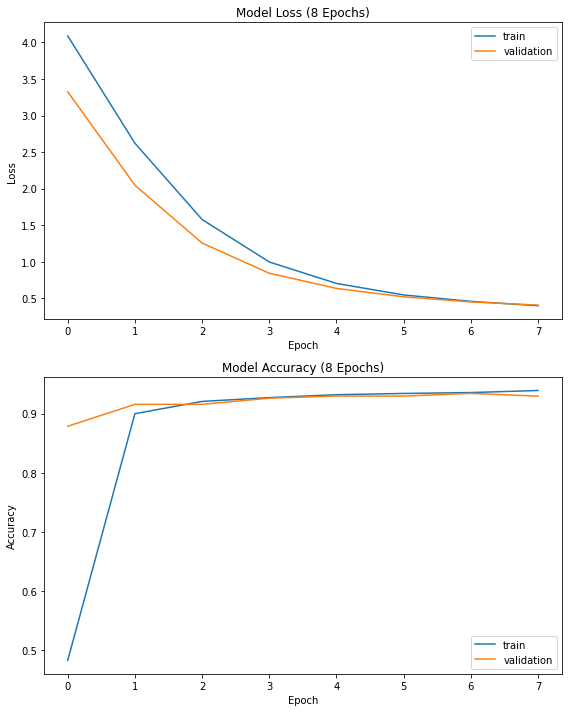

In [15]:
fig,ax = plt.subplots(2,1,figsize=(8,10))

#LOSS
ax[0].plot(loss)
ax[0].plot(val_loss)
ax[0].set_title('Model Loss (8 Epochs)')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['train','validation'])

#LOSS
ax[1].plot(accuracy)
ax[1].plot(val_accuracy)
ax[1].set_title('Model Accuracy (8 Epochs)')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['train','validation'])

plt.tight_layout()

## Prediction on Test Data

In [22]:
%%time
pred = model.predict(test_generator)
print("Shape of Test Prediction Dataframe:",pred.shape)

Shape of Test Prediction Dataframe: (1533, 120)
CPU times: user 22min 24s, sys: 23min 58s, total: 46min 22s
Wall time: 11min 25s


In [23]:
predicted_df = pd.DataFrame(pred, columns=all_breeds.breed)
predicted_df.head()

breed,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.005386,0.001980,0.002894,0.000864,0.002422,0.003500,0.001501,0.002761,0.002982,0.001835,...,0.006440,0.009699,0.001963,0.001460,0.003415,0.001771,0.004746,0.002410,0.001217,0.007073
1,0.000428,0.001618,0.000809,0.001055,0.000401,0.000771,0.000233,0.000347,0.000762,0.000633,...,0.000356,0.000501,0.001139,0.000743,0.000487,0.000541,0.000559,0.000668,0.000988,0.000219
2,0.001842,0.001158,0.001117,0.002348,0.001085,0.001054,0.000528,0.001130,0.000793,0.001122,...,0.001161,0.000574,0.001311,0.000990,0.001089,0.000545,0.001222,0.001550,0.001749,0.000901
3,0.001764,0.001882,0.001362,0.001274,0.000971,0.001789,0.001874,0.001201,0.000899,0.000871,...,0.002847,0.001408,0.001432,0.001367,0.001303,0.002515,0.001220,0.002068,0.001477,0.002097
4,0.000865,0.001001,0.872062,0.001378,0.000973,0.001101,0.001760,0.000609,0.000827,0.000526,...,0.000937,0.000486,0.000688,0.000779,0.000904,0.001241,0.000815,0.001740,0.001633,0.001499


In [24]:
#Return column index of each example based on max predicted probability across 120 breeds
final_preds = predicted_df.idxmax(axis=1)
final_preds[1:10]

1                 otterhound
2            giant_schnauzer
3                groenendael
4        african_hunting_dog
5    wire-haired_fox_terrier
6                 schipperke
7                     kelpie
8                 pomeranian
9                entlebucher
dtype: object

In [25]:
#Append predictions to test_df
final_pred_df = test_df.copy()
final_pred_df.reset_index(drop = True, inplace = True)
final_pred_df['predicted_breed'] = final_preds
final_pred_df.head()

,id,breed,predicted_breed
0,001cdf01b096e06d78e9e5112d419397.jpg,pekinese,pekinese
1,008ba178d6dfc1a583617470d19c1673.jpg,otterhound,otterhound
2,00fda6ecca54efbac26e907be4b0b78b.jpg,giant_schnauzer,giant_schnauzer
3,010e87fdf252645a827e37470e65e842.jpg,groenendael,groenendael
4,014c2b0cd8e3b517e649cecf8543b8fe.jpg,african_hunting_dog,african_hunting_dog


In [26]:
misclassified_tot = final_pred_df.query("breed != predicted_breed").shape[0]
correct_tot = final_pred_df.query("breed == predicted_breed").shape[0]
total_attempted = final_pred_df.shape[0]
print(f"Correctly classified {correct_tot}/{total_attempted} dog breeds leaving {misclassified_tot} misclassified.")
print(f"Test Set Accuracy: {correct_tot/total_attempted*100}")

Correctly classified 1433/1533 dog breeds leaving 100 misclassified.
Test Set Accuracy: 93.47684279191128


# Conclusion
The model returned an accuracy of ~93.5% when predicting dog breeds on unseen test data. Given the large number of classes, the relative similarity in appearance between multiple dog breeds, and the variation of picture inputs, this is an excellent result.

The visualizations presented above relating to loss and accuracy show that the CNN created in keras yielded an acceptable performance after around 2 epochs during training. This is most likely attributable to the usage of the NASNet-Large pretrained layers implemented in the model, which saved the model from having to retrain over 80 million parameters. 

# Future Analysis


This foray merely scratches the surface of what is possible with CNNs. Because of the cumbersome computational complexity and subsequent runtime associated with training the model, large-scale hyperparameter tuning was infeasible. Further routes of exploration relating to hyperparameter tuning include:
* Changing the ratio between the training and validation sets specified in the model initialization phase
* Adding to the data augmentation step implemented with the ImageDataGenerator class
* Changing the model blueprint itself vis a vis adding layers/nodes
* Uncountable others

As an attempt to bring value to theoretical stakeholders in this exploration, the team delved into creating a standalone webapp by which a user would upload a picture of their dog, and the trained model would yield a prediction as to its most-likely breed among the 120 breeds that the model had learned. A brief overview of the application is available in the accompanying whitepaper / presentation.

# Citations
The following links were used for research purposes and to supplement this project:  
* https://www.kaggle.com/c/dog-breed-identification/overview
* https://www.kaggle.com/jithinanievarghese/dog-breed-identification-keras-nasnetlarge-93-63/notebook#Data-preprocessing
* https://www.researchgate.net/post/what_is_the_difference_between_validation_set_and_test_set
* https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/
* https://stackoverflow.com/questions/34518656/how-to-interpret-loss-and-accuracy-for-a-machine-learning-model
* https://keras.io/
* https://www.tensorflow.org/guide/keras/sequential_model
* https://lionbridge.ai/articles/difference-between-cnn-and-rnn/